In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [18,10]

### Dominant colors in images
- All images consist of pixels 
- Each pixel has three values :RGB
- Perform k-means on standardized RGB values to find cluster centers
- Uses: Identify features in satellite images

### Tools to find dominant colors
- Convert image to pixels: `matplotlib.image.imread`
- Display colors of cluster centers: `matplotlib.pyplot.imshow`

In [3]:
import matplotlib.image as img
image = img.imread('data/sea.jpg')
image.shape

(810, 1305, 3)

In [4]:
r = []
g = []
b = []

for row in image:
    for pixel in row: 
        # A pixel contains RGB values
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

In [5]:
from scipy.cluster.vq import whiten

In [6]:
pixels = pd.DataFrame({'red': r,
                      'blue': b,
                      'green': g,
                      'scaled_red': whiten(r),
                      'scaled_green': whiten(g),
                      'scaled_blue': whiten(b)})

In [7]:
from scipy.cluster.vq import kmeans, vq

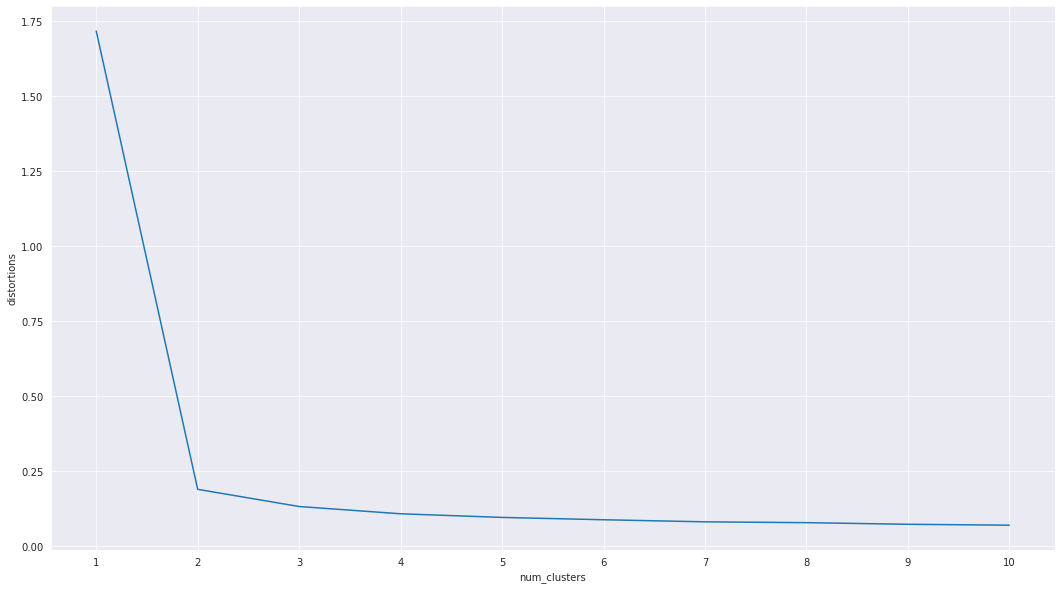

In [8]:
distortions = []
num_clusters = range(1, 11)

# Create a list of distortions from the kmeans method
for i in num_clusters: 
    cluster_centers, distortion = kmeans(pixels[['scaled_red', 'scaled_blue', 'scaled_green']], i)
    distortions.append(distortion)
    
# Create a data frame with two list - number of clusters and distortions 
elbow_plot = pd.DataFrame({'num_clusters': num_clusters,
                          'distortions': distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

### Find dominant colors

In [9]:
cluster_centers, _ = kmeans(pixels[['scaled_red', 'scaled_blue', 'scaled_green']], 2)

In [10]:
colors = []

# Find Standard Deviations 
r_std, g_std, b_std = pixels[['red', 'green', 'blue']].std()

# Scale actual RGB values in range of 0-1
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((
        scaled_r * r_std/255,
        scaled_g * g_std/255,
        scaled_b * b_std/255
    ))

### Display dominant colors

In [11]:
#Dimensions: 2 x 3 (N x 3 matrix)
print(colors)

[(0.892953171123333, 0.9834286890957886, 0.8213044431555168), (0.08012482861586387, 0.37300684380669996, 0.2573556985103397)]


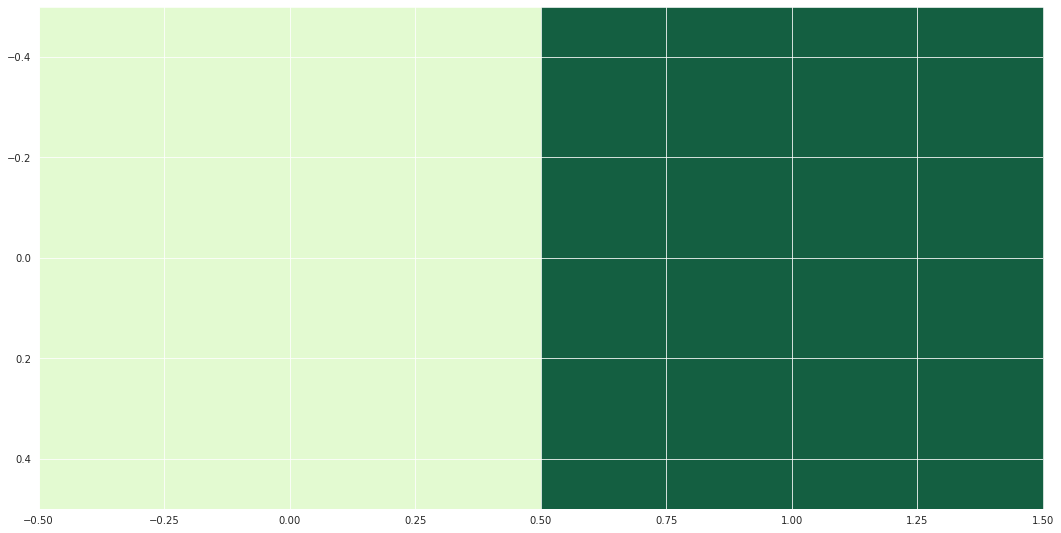

In [12]:
#Dimensions 1 x 2 x 3 (1 x N x 3 matrix)
plt.imshow([colors])
plt.show()

In [13]:
r = []
g = []
b = []

In [14]:
# Import image class of matplotlib
import matplotlib.image as img

# Read batman image and print dimensions
batman_image = img.imread('data/batman.jpg')
print(batman_image.shape)

# Store RGB values of all pixels in lists r, g and b
for pixel in batman_image:
    for temp_r, temp_g, temp_b in pixel:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

(169, 269, 3)


In [15]:
batman_df = pd.DataFrame({'red': r,
                         'green': g,
                         'blue': b,
                         'scaled_red': whiten(r),
                         'scaled_green': whiten(g),
                         'scaled_blue': whiten(b)})

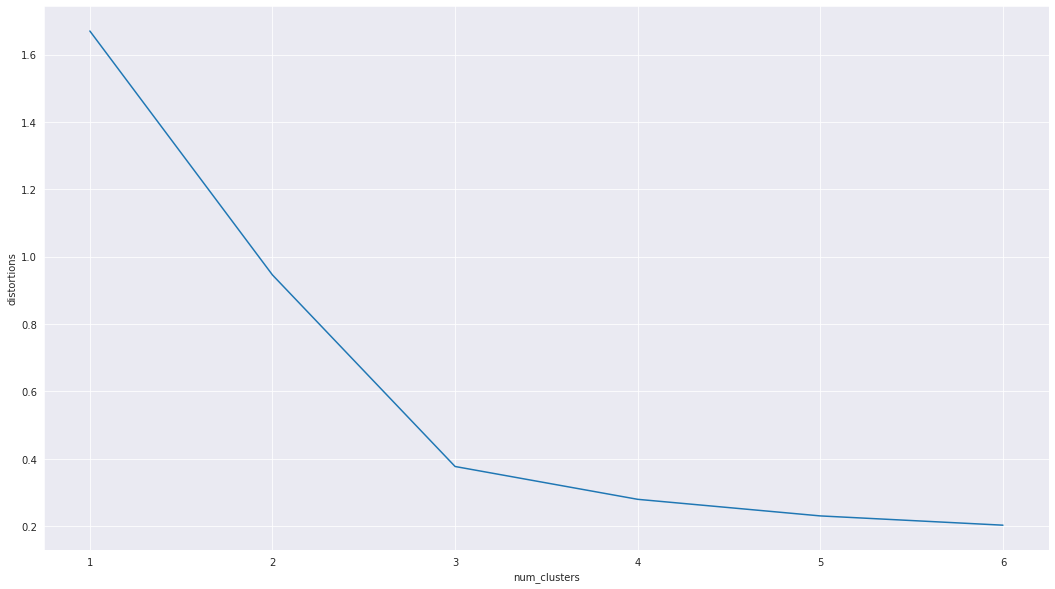

In [16]:
distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(batman_df[['scaled_red', 'scaled_blue','scaled_green']], i)
    distortions.append(distortion)

# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters,
                         'distortions': distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

In [17]:
cluster_centers, _ = kmeans(batman_df[['scaled_red', 'scaled_green', 'scaled_blue']], 3)
colors = []

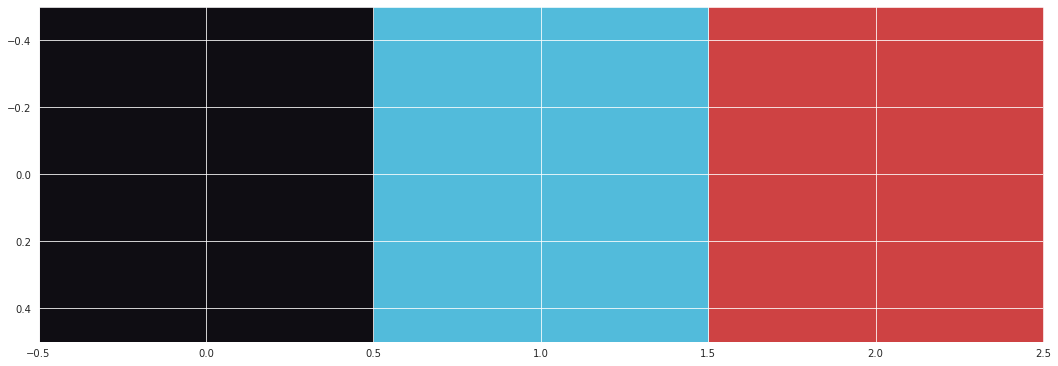

In [18]:
# Get standard deviations of each color
r_std, g_std, b_std = batman_df[['red', 'green', 'blue']].std()

for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    # Convert each standardized value to scaled value
    colors.append((
        scaled_r * r_std / 255,
        scaled_g * g_std / 255,
        scaled_b * b_std / 255
    ))

# Display colors of cluster centers
plt.imshow([colors])
plt.show()

### Document clustering
1. Clean data before processing
2. Determine the importance of the terms in a document (in TF-IDF matrix)
3. Cluster the TF-IDF matrix
4. Find top terms, documents in each cluster

### Clean and tokenize data
- Convert text to into smaller parts called tokens, clean data for processing

In [19]:
from nltk.tokenize import word_tokenize
import re

def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            #Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

data = remove_noise("It is lovely weather we are having.\
              I hope the weather continues.",
             stop_words = ['it', 'is', 'we', 'the'])
data

['lovely', 'weather', 'are', 'having', 'hope', 'weather', 'continues']

### Document term matrix and sparse matrices
- Document term matrix formed
- Most elements in matrix are zero

![matrix](data/matrix.png)

- Sparse matrix is created

![sparse_matrix](data/sparse_matrix.png)

### TF-IDF(Term Frequency - Inverse Document Frequency)
- A weighted measure: evaluate how important a word is to a document in a collection

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=50,
                                 min_df=0.2, tokenizer=remove_noise)

tfidf_matrix = tfidf_vectorizer.fit_transform(data)

### Clustering with sparse matrix
- `kmeans` in SciPy does not support sparse matrices
- Use `.todense()` to convert a matrix

In [22]:
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), 2)

### Top terms per cluster
- Cluster centers: lists with a size equal to the number of terms
- Each value in the cluster center is its importance
- Create a dictionary and print top terms

In [33]:
terms = tfidf_vectorizer.get_feature_names()

for i in range(len(terms)):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['weather']


### More considerations

- Work with hyperlinks, emoticons etc.
- Normalize words (run, ran, running -> run)
- `.todense()` may not work with large datasets

In [34]:
stop_words_2 = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'dont', 'should', 'shouldve', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'arent', 'couldn', 'couldnt', 'didn', 'didnt', 'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 'haven', 'havent', 'isn', 'isnt', 'ma', 'mightn', 'mightnt', 'mustn', 'mustnt', 'needn', 'neednt', 'shan', 'shant', 'shouldn', 'shouldnt', 'wasn', 'wasnt', 'weren', 'werent', 'won', 'wont', 'wouldn', 'wouldnt']


def remove_noise(text, stop_words = stop_words_2):

    tokens = word_tokenize(text)

    cleaned_tokens = []

    for token in tokens:

        token = re.sub('[^A-Za-z0-9]+', '', token)

        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())

    return cleaned_tokens

In [40]:
movies = pd.read_csv('data/movies_plot.csv')
plots = movies['Plot'].values

In [41]:
# Import TfidfVectorizer class from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, max_features=50,
                                  min_df=0.1, tokenizer=remove_noise)

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

In [42]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

In [44]:
for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['film', 'life', 'new']
['one', 'back', 'two']


In [ ]:
!..